In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


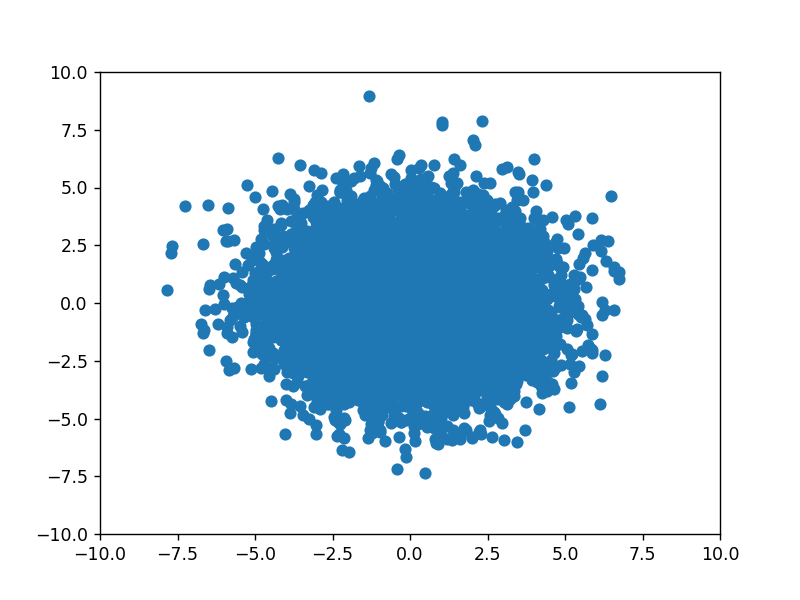

(-10.0, 10.0)

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=10000, centers=[(0,0)], n_features=2, cluster_std=2, random_state=42, shuffle=True)

plt.figure()
plt.scatter(X.T[0], X.T[1])

plt.ylim(-10,10)
plt.xlim(-10,10)

In [3]:
def gaussian(x, μ, σ):
    return (1/(np.sqrt(2*np.pi)*σ)) * np.exp(-(x - μ)**2/(2 * σ**2))

In [4]:
def p(x):
    # Mean and variance of the features
    mean = np.array([np.mean(X.T[i]) for i in range(len(X.T))])
    var = np.array([np.mean((X.T[i] - mean[i])**2) for i in range(len(X.T))])
        
    return np.prod([gaussian(x[i], mean[i], var[i]) for i in range(len(X.T))])

In [9]:
def is_anomaly(x_test, ϵ=10e-7):
    if p(x_test) < ϵ:
        return True
    else:
        return False

In [11]:
x_test = np.array([-20,20])
is_anomaly(x_test)

True